In [1]:
from env.env import PICK_TARGETS, PLACE_TARGETS, PickPlaceEnv
import clip
import torch
import cv2
import numpy as np

from vild.forward import vild
import imageio

pybullet build time: Mar  1 2023 12:07:22


In [2]:
device = 'cuda'

In [3]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.to(device).eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [4]:
env  = PickPlaceEnv()
# Coordinate map (i.e. position encoding).
coord_x, coord_y = np.meshgrid(np.linspace(-1, 1, 224), np.linspace(-1, 1, 224), sparse=False, indexing='ij')
coords = np.concatenate((coord_x[..., None], coord_y[..., None]), axis=2)

In [21]:
category_names = [
                    'blue block',
                  'red block',
                  'green block',
                  'orange block',
                  'yellow block',
                  'purple block',
                  'pink block',
                  'cyan block',
                  'brown block',
                  'gray block',

                  'blue bowl',
                  'red bowl',
                  'green bowl',
                  'orange bowl',
                  'yellow bowl',
                  'purple bowl',
                  'pink bowl',
                  'cyan bowl',
                  'brown bowl',
                  'gray bowl',
                  
                  ]


# category_names = ['yellow block','red block', 'orange block',
#             'green bowl','brown bowl']

#@markdown ViLD settings.
category_name_string = ";".join(category_names)
max_boxes_to_draw = 8 #@param {type:"integer"}

# Extra prompt engineering: swap A with B for every (A, B) in list.
# prompt_swaps = [('block', 'cube')]

nms_threshold = 0.4 #@param {type:"slider", min:0, max:0.9, step:0.05}
min_rpn_score_thresh = 0.4  #@param {type:"slider", min:0, max:1, step:0.01}
min_box_area = 10 #@param {type:"slider", min:0, max:10000, step:1.0}
max_box_area = 3000  #@param {type:"slider", min:0, max:10000, step:1.0}
vild_params = max_boxes_to_draw, nms_threshold, min_rpn_score_thresh, min_box_area, max_box_area


In [22]:
raw_input = "put a block that user wants in red bowl." 
config = {"pick":  ["red block", "blue block", "green block", "orange block", "yellow block", "purple block"],
          "place": [ 'cyan bowl','pink bowl']}

termination_string = "done()"

[-0.02560204 -0.6896295   0.05      ]
[ 0.01986499 -0.52587104  0.05      ]
[-0.11814056 -0.4522916   0.05      ]


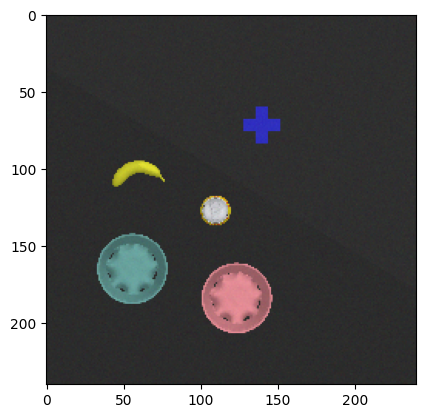

In [23]:
image_path = "./2db.png"
np.random.seed(2)
if config is None:
  pick_items = list(PICK_TARGETS.keys())
  pick_items = np.random.choice(pick_items, size=np.random.randint(1, 5), replace=False)

  place_items = list(PLACE_TARGETS.keys())[:-9]
  place_items = np.random.choice(place_items, size=np.random.randint(1, 6 - len(pick_items)), replace=False)
  config = {"pick":  pick_items,
            "place": place_items}
  print(pick_items, place_items)

obs = env.reset(config)

img_top = env.get_camera_image_top()
img_top_rgb = cv2.cvtColor(img_top, cv2.COLOR_BGR2RGB)
plt.imshow(img_top)

imageio.imsave(image_path, img_top)

## VILD

In [24]:
vild_model = vild(clip_model,category_name_string, vild_params)

INFO:tensorflow:Restoring parameters from ./image_path_v2/variables/variables


In [25]:
# prompt_swaps = [('circle','bowl')]

In [26]:
vild_model.category_name_string

'blue bowl;red bowl;green bowl;orange bowl;yellow bowl;purple bowl;pink bowl;cyan bowl;brown bowl;gray bowl;bottle;can;apple;banana;camera'

Building text embeddings...


100%|██████████| 16/16 [00:00<00:00, 48.48it/s]


Found a cyan bowl with score: 0.2912936
Found a apple with score: 0.28543308
Found a banana with score: 0.27676323
Found a yellow bowl with score: 0.27196175


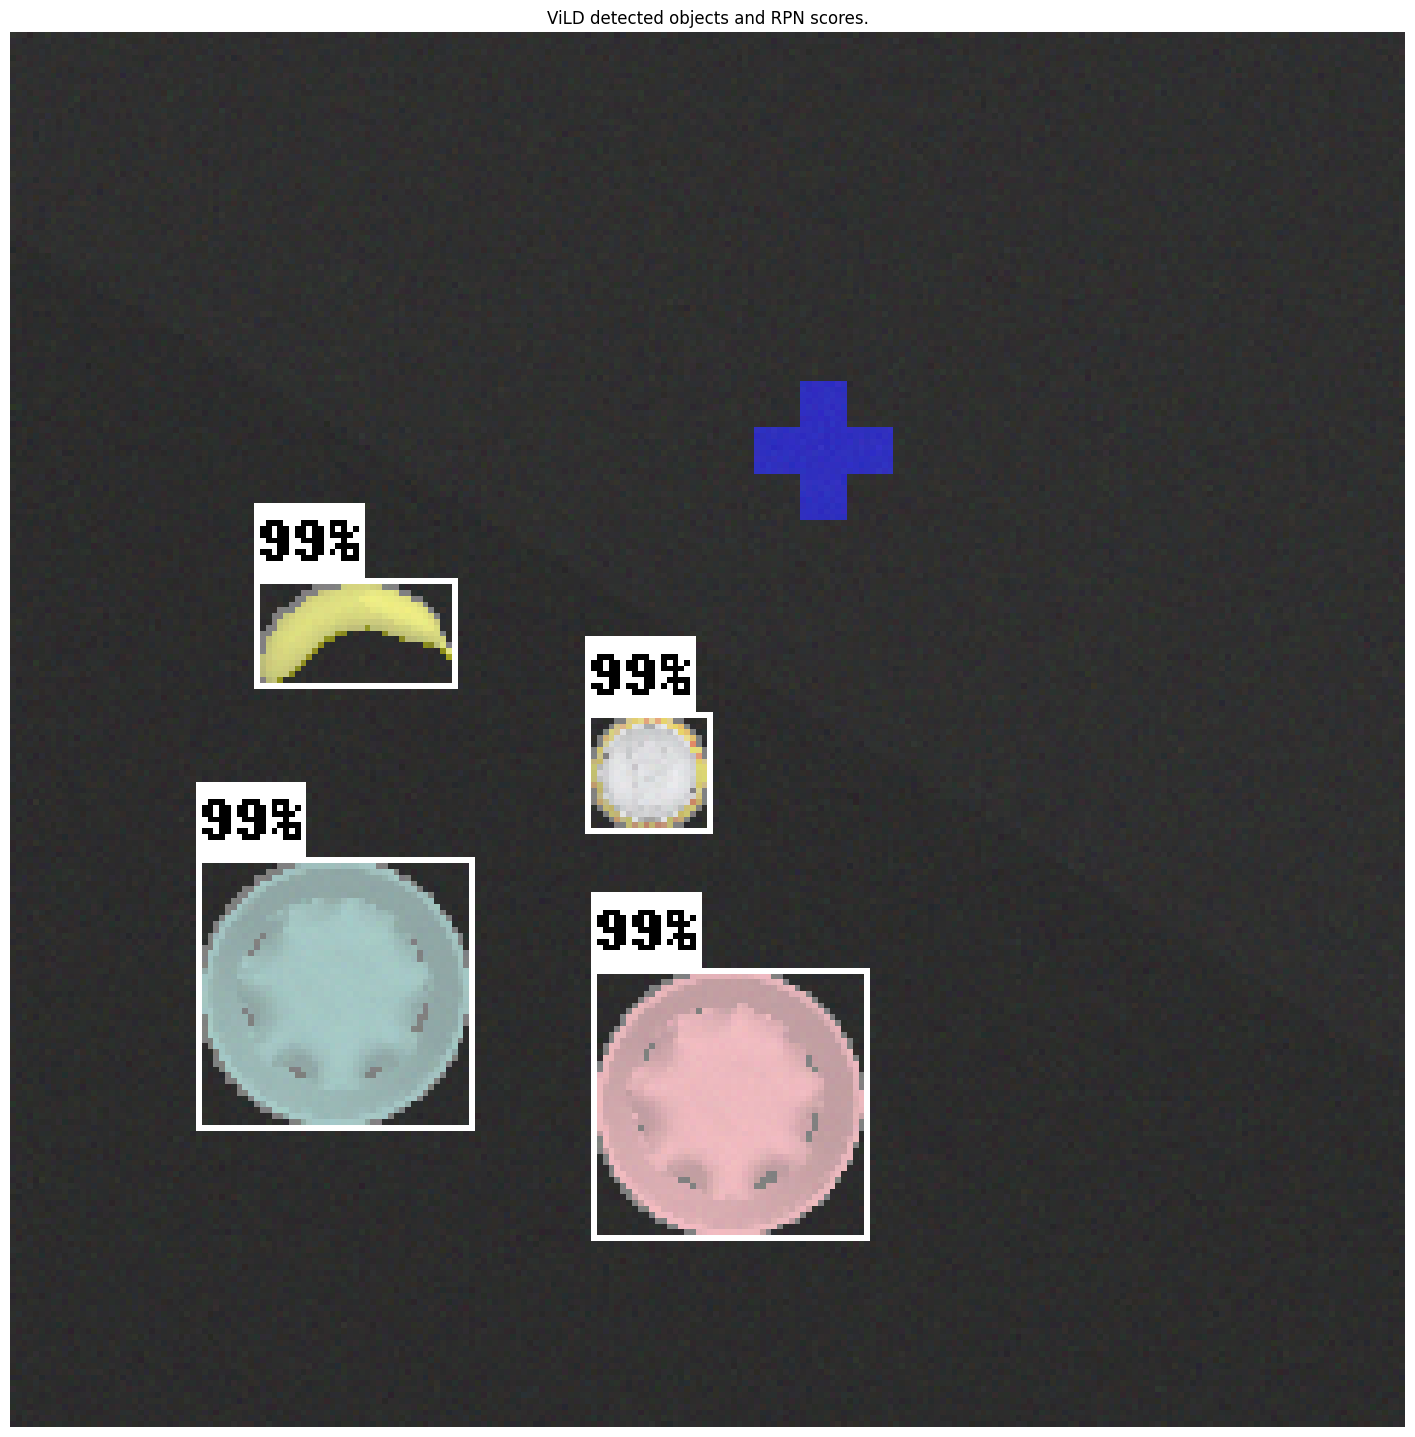

In [27]:
found_objects, boxes = vild_model.infer(image_path,plot_on=True,prompt_swaps=[])


In [28]:
found_objects

['cyan bowl', 'apple', 'banana', 'yellow bowl']

## OWL-VIT

In [34]:
from PIL import Image

from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

In [35]:
device = 'cuda:1'

In [36]:
model = model.to(device)

In [80]:
text_queries = category_names

img_top = env.get_camera_image_top()
image = Image.fromarray(img_top).convert("RGB")

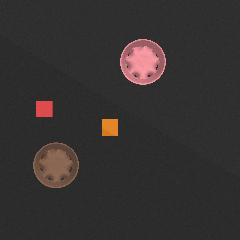

In [81]:
image

In [82]:
# Process image and text inputs
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

In [83]:
model.eval()

# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}") 

logits: shape of torch.Size([1, 576, 20])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 20, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([20, 16, 512])
pooler_output: shape of torch.Size([20, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


In [84]:
from transformers.image_utils import ImageFeatureExtractionMixin
from vild.nms import nms
mixin = ImageFeatureExtractionMixin()

# Load example image
image_size = model.config.vision_config.image_size
image = mixin.resize(image, image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 5e-3

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

nms_threshold = 0.4
nmsed_indices = nms(
        boxes,
        scores,
        thresh=nms_threshold
        )

scores = scores[nmsed_indices]
boxes = boxes[nmsed_indices]
labels = labels[nmsed_indices]

In [85]:
len(nmsed_indices), labels.shape

(542, (542,))

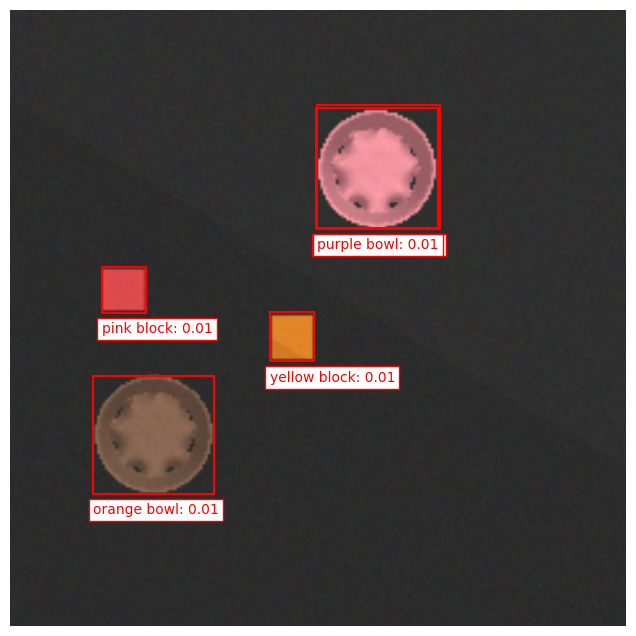

In [86]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      # print(score)
      if score < score_threshold:
        continue
      # print("plot")
      cx, cy, w, h = box
      if w> 0.5 or h>0.5 or w<0.01 or h< 0.01:
        continue
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })
    
plot_predictions(input_image, text_queries, scores, boxes, labels)